# **Plan of the work:**

1)Take a model

2)train it on CIFAR100

3)check PpC (Performance per Class)

4)check PpC under pgd-attack

5)train model adversarially

6)Check PpC after adversarial training

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict

import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed(42)

#Model

#Dataset

In [ ]:
import json 
import os
from pathlib import Path

# your api key
api_key = {"username":"spacehitchhiker","key":"c698b877d42f3f853d0a599e6263d8a8"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

!kaggle datasets download -d akash2sharma/tiny-imagenet

!unzip -qq tiny-imagenet.zip

 99% 472M/474M [00:22<00:00, 23.8MB/s]
100% 474M/474M [00:22<00:00, 22.1MB/s]


In [ ]:
def load_dataset(data_path):
    # Load all the images
    transformation = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
    ])

    full_dataset = datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (90% and testing (10%) datasets)
    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    return train_loader, test_loader

train_folder = '/content/tiny-imagenet-200/train'
# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)

In [ ]:
x,y  = next(iter(test_loader))
y

tensor([ 81,  57, 127, 120,  89, 103, 135, 170,  19,  52, 120,   1, 112, 110,
        188,  16, 146,  27,  59,   4,  42, 115,  55, 165, 138,   5,  12,  28,
        122,  21,  54,  99])

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move model to designated device (Use GPU when on Colab)
model = model.to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Loaded pretrained weights for efficientnet-b3


#Training on clean data

In [ ]:
epochs = 5

lr = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

loss_history = []
acc_history = []
acc_eval_history = []
loop = tqdm(range(epochs))
for epoch in loop:

  train_loss = 0
  train_acc = 0
  eval_acc = 0
  model.train()
  for x,y in train_loader:
    optimizer.zero_grad()
    x,y = x.to(device), y.to(device)
    logits = model(x)
    loss = criterion(logits,y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += (logits.argmax(dim=1) == y).sum().item() / len(y)

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  loss_history.append(train_loss)
  acc_history.append(train_acc)

  model.eval()
  for x,y in test_loader:
    x, y = x.to(device), y.to(device)
    logits = model(x)
    eval_acc += (logits.argmax(dim=1) == y).sum().item() / len(y)

  eval_acc /= len(test_loader)
  acc_eval_history.append(eval_acc)

  lr = optimizer.param_groups[0]['lr']
  loop.set_description(f'Loss:{round(train_loss,2)} train_acc: {round(train_acc,3)} val_acc:{round(eval_acc,2)} lr :{lr}')

Loss:1.98 train_acc: 0.502 val_acc:0.48 lr :0.001: 100%|██████████| 5/5 [31:21<00:00, 376.25s/it]


In [ ]:
best_state_dict = model.state_dict()

torch.save(best_state_dict,f'model_best.pth')

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()
model.to(device)

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

#Check PpC on clean data

In [ ]:
def PpC_measure(dataloader,model,num_classes):
  '''
  Return accuracy per class
  '''
  images_per_class = {i: 0 for i in range(num_classes)}
  correct_per_class = {i: 0 for i in range(num_classes)}

  for x,y in dataloader:
    x,y = x.to(device), y.to(device)
    preds = model(x).argmax(1)
    for i in range(num_classes):
      images_per_class[i] += (y == i).sum().item()
      correct_per_class[i] += (preds[y==i] == i).sum().item()
  
  for i in range(num_classes):
    correct_per_class[i] /= images_per_class[i]
  
  return correct_per_class

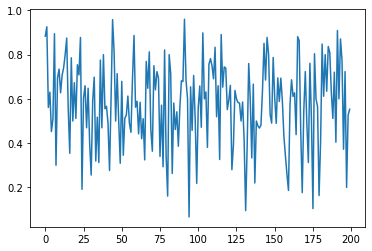

In [ ]:
acc_per_class_clean = PpC_measure(test_loader,model,num_classes=200)

classes = list(acc_per_class_clean.keys())
values = list(acc_per_class_clean.values())

plt.plot(classes,values)

#PpC under attacks

In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 14.3 MB/s eta 0:00:00


In [ ]:
from torchattacks.attacks.pgd import PGD

In [ ]:
def PpC_attack(dataloader,model,num_classes):
  '''
  Return accuracy per class with poisoned data
  '''
  images_per_class = {i: 0 for i in range(num_classes)}
  correct_per_class = {i: 0 for i in range(num_classes)}

  attack = PGD(model, eps=3/255, alpha=1/255, steps=5, random_start=True)

  for x,y in tqdm(dataloader):
    x,y = x.to(device), y.to(device)
    preds_clean = model(x).argmax(1)
    adv_images = attack(x,y)
    preds_adv = model(adv_images).argmax(1)
    for i in range(num_classes):
      images_per_class[i] += (y == i).sum().item()
      correct_per_class[i] += ((preds_clean[y==i] == i) * (preds_adv[y==i] == i)).sum().item()
  
  for i in range(num_classes):
    correct_per_class[i] /= images_per_class[i]
  
  return correct_per_class

In [ ]:
acc_per_class_attack = PpC_attack(test_loader,model,num_classes=200)

classes_a = list(acc_per_class_attack.keys())
values_a = list(acc_per_class_attack.values())

100%|██████████| 313/313 [02:02<00:00,  2.56it/s]


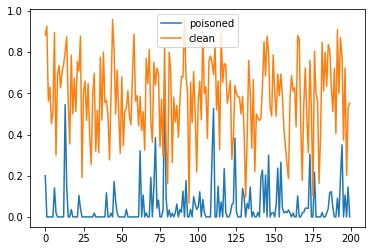

In [ ]:
plt.plot(classes_a,values_a,label='poisoned')
plt.plot(classes,values,label='clean')
plt.legend()

**Match of easy classes**

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([i[0] for i in sort_acc[-30:]]))
print(labels)
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([i[0] for i in sort_acc[-30:]]))
print(labels)

[  0   1   6  11  12  14  21  22  44  58  78  81  91 108 110 115 133 145
 146 154 165 166 170 173 176 181 186 189 191 193]
[ 13  14  22  62  69  72  78  89  90  92 101 103 109 110 117 124 129 134
 141 142 144 146 151 152 154 171 172 173 176 194]


**Match of hard classes**

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([i[0] for i in sort_acc[:40]]))
print(labels)
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([i[0] for i in sort_acc[:40]]))
print(labels)

[  7  16  24  30  35  37  49  55  63  75  77  79  80  83  87  94  96  99
 102 106 112 123 130 131 132 135 137 139 140 155 156 158 159 164 168 172
 175 177 179 197]
[ 1  2  3  4  5  8 12 15 18 20 24 25 26 27 29 30 31 33 34 35 36 37 38 39
 41 43 44 47 48 49 50 53 54 55 56 57 58 59 60 61]


In [ ]:
attack = PGD(model, eps=8/255, alpha=2/255, steps=10, random_start=True)
images,labels = next(iter(test_loader))
images,labels = images.to(device),labels.to(device)
adv_images = attack(images, labels)

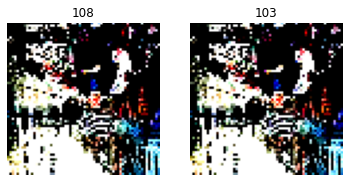

tensor(108, device='cuda:0')


In [ ]:
fig,axes = plt.subplots(1,2)
index = 16
pr_clean = model(images[index].unsqueeze(0)).argmax(1).item()
pr_attack = model(adv_images[index].unsqueeze(0)).argmax(1).item()
axes[0].imshow(images[index].cpu().permute(1,2,0).clip(0,1))
axes[0].set_title(f'{pr_clean}')
axes[1].set_title(f'{pr_attack}')
axes[1].imshow(adv_images[index].cpu().permute(1,2,0).clip(0,1))
axes[0].axis('off')
axes[1].axis('off')
plt.show()
print(labels[index])

#Adversarial Training

In [ ]:
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'

train_folder = '/content/tiny-imagenet-200/train'
# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=0.5e-3)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

Loaded pretrained weights for efficientnet-b3


In [ ]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
epochs = 20
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0

    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                grad = delta.grad.detach()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
                optimizer.zero_grad()
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            loss.backward()
            optimizer.step()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)}')

train acc: 0.301:  20%|██        | 4/20 [1:03:39<4:14:36, 954.79s/it]


KeyboardInterrupt: ignored

In [ ]:
best_state_dict = model.state_dict()

torch.save(best_state_dict,'model_at.pth')

In [ ]:
NUM_CLASSES = 200

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):

    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()

    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)

            scaler.scale(loss).backward()
            grad = delta.grad.detach()

            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])

            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return test_loss/n, test_acc/n,acc_per_class


In [ ]:
# Evaluation
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)
model.load_state_dict(torch.load('model_at.pth'))
model.eval()
model.to(device)


pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
test_loss, test_acc, acc_cl_standart_at = evaluate_standard(test_loader, model)
print(test_acc,pgd_acc)

Loaded pretrained weights for efficientnet-b3


100%|██████████| 313/313 [00:24<00:00, 12.75it/s]

0.4854 0.265


#PpC after adv training

In [ ]:
classes_at = list(acc_cl_pgd_at.keys())
values_at = list(acc_cl_pgd_at.values())
print(acc_cl_pgd_at)

{0: 0.55, 1: 0.7037037037037037, 2: 0.21052631578947367, 3: 0.043478260869565216, 4: 0.19047619047619047, 5: 0.04081632653061224, 6: 0.40350877192982454, 7: 0.12, 8: 0.6326530612244898, 9: 0.22448979591836735, 10: 0.0784313725490196, 11: 0.1951219512195122, 12: 0.29310344827586204, 13: 0.6, 14: 0.525, 15: 0.2153846153846154, 16: 0.125, 17: 0.2857142857142857, 18: 0.13157894736842105, 19: 0.23076923076923078, 20: 0.3953488372093023, 21: 0.5263157894736842, 22: 0.2916666666666667, 23: 0.40816326530612246, 24: 0.0, 25: 0.2916666666666667, 26: 0.3404255319148936, 27: 0.04081632653061224, 28: 0.12962962962962962, 29: 0.08888888888888889, 30: 0.23255813953488372, 31: 0.14814814814814814, 32: 0.09433962264150944, 33: 0.1702127659574468, 34: 0.13793103448275862, 35: 0.08333333333333333, 36: 0.4489795918367347, 37: 0.20408163265306123, 38: 0.2222222222222222, 39: 0.15555555555555556, 40: 0.15, 41: 0.15789473684210525, 42: 0.0425531914893617, 43: 0.12727272727272726, 44: 0.75, 45: 0.534482758620

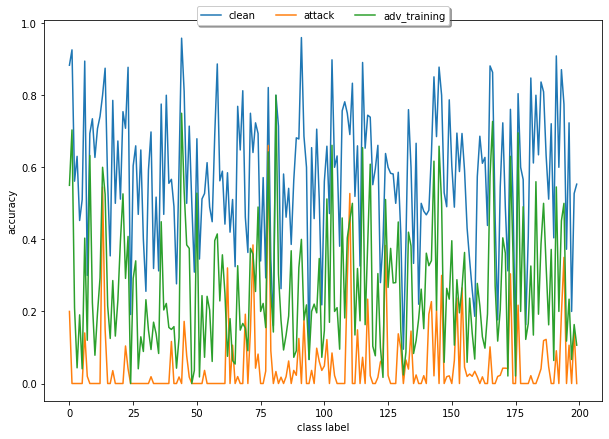

In [ ]:
x = [classes,classes_a,classes_at] 
y = [values,values_a,values_at]
labels = ['clean','attack','adv_training']
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(111)

for i in range(3):
    line, = ax.plot(x[i], y[i], label=labels[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('class label')
plt.ylabel('accuracy')
plt.show()


#Check match of easy classses

On coarse labels

In [ ]:
def print_list(arr):
  for i in range(0,len(arr),5):
    print(arr[i:i+3],sep=' ')
  print('-'*10)


In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[-25:]])))
print('on clear images',labels,end='\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[-25:]])))
print('on poisoned images',labels)
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[-25:]])))
print('after adv training',labels)

on clear images [0, 1, 6, 14, 23, 44, 45, 58, 68, 78, 91, 103, 111, 115, 143, 145, 165, 166, 176, 181, 183, 185, 186, 191, 193]
on poisoned images [0, 13, 14, 45, 62, 69, 71, 72, 78, 92, 109, 110, 113, 117, 124, 141, 142, 144, 146, 152, 154, 173, 176, 193, 194]
after adv training [0, 1, 8, 13, 14, 21, 44, 45, 50, 78, 81, 101, 103, 115, 118, 124, 143, 145, 165, 166, 173, 176, 183, 191, 194]


Easy classes:
0,1,14,44,45,78,103,115,143,145, 165, 166,176, 183, 191

#Check match of hard classes

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[:25]])))
print('on clear images',labels,end='\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[:25]])))
print('on poisoned images',labels)
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = list(np.unique(np.array([i[0] for i in sort_acc[:25]])))
print('after adv training',labels)

on clear images [7, 24, 30, 33, 35, 42, 49, 65, 77, 80, 83, 94, 99, 114, 122, 131, 135, 137, 158, 159, 168, 172, 175, 179, 197]
on poisoned images [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 33]
after adv training [3, 5, 24, 27, 42, 48, 49, 51, 53, 56, 62, 64, 65, 88, 94, 99, 123, 131, 147, 156, 159, 172, 175, 190, 197]


Hard classes:24,42,49,65,94,99,131,159,172, 175, 197

On fine labels